<a href="https://colab.research.google.com/github/varinen/handson-unsupervised-learning/blob/master/Chap10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender System Using Restricted Boltzmann Machines

We are goind to work with *generative model* that learn the probability distribution of the data. The use this knowledge to make inferences on never-before-seen data that is they produce new data that is very close to the real data.

The simplest generative model is the **restricted Boltzmann machine**.

## Boltzmann Machines

Boltzmann Machines were invented in 1985 by Geoffrey Hinton and Terry Sejnowski. **Unrestricted Boltzmann machines** constist of one input layer and one or several hidden layers. During training, neurons in the layers make stochastic desicions when to fire or not based on input data fed to the machine and a cost function that this machine ries to minimize. As the result of this training, a Boltzmann machine learns interesting features abotu the data that help it to model the complex relationships and patterns in the original dataset.

However, neurons in such machines are connected not only to neurons in other layers but also to other neurons within the same layer. This makes the training of unrestricted Boltzmann machines very inefficient.

### Restricted Boltzmann Machines

A simpler version of Boltzmann machines was proposed by Hinton in 2000. It consist only of one input and one hidden layers. It is also **restricted** so that neurons can only connect to neurons on other layers but not within the same one.

It was demostrated that stacking of several restricted Boltzmann machines (the output on the hidden layer of one machine is fed into the input layer of the next one) can help learning more nuanced hidden structures in data.

Boltzmann machines use *stochastic* approach to learning while autoencoder use *deterministic* approach.


For this project we are going to build a recommender system using restricted Boltzmann machines. The recommendations are based on the MovieLens dataset.


In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime
from datetime import datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


Next, we are going to load the dataset. The dataset is located on Google drive and this will require some additional code to get access to the file.

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

In [0]:
drive = GoogleDrive(gauth)

shareable_link = 'https://drive.google.com/open?id=1trRaJZ639WysCW8mLpmFS1f55o3YYsNq'
fluff, id = shareable_link.split('=')
print(id)


1trRaJZ639WysCW8mLpmFS1f55o3YYsNq


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
data = pd.read_csv('Filename.csv')

In [0]:
data.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


The dataset entries have four columns: `user_id`, `movie_id`, `rating`. The last column, `timestamp`, indicates the time the rating was given. There are over 20 million ratings in the dataset.

In [0]:
print(data.shape)
'''
MovieLens 20M Dataset
20,000,263 ratings
27,278 movies
138,493 users
'''

(20000263, 4)


'\nMovieLens 20M Dataset\n20,000,263 ratings\n27,278 movies\n138,493 users\n'

Before we can proceed, we need to convert the dataset columns into appropriate data types.

In [0]:
ratingDF = data
# Convert fields into appropriate data types
ratingDF.userId = ratingDF.userId.astype(str).astype(int)
ratingDF.movieId = ratingDF.movieId.astype(str).astype(int)
ratingDF.rating = ratingDF.rating.astype(str).astype(float)
ratingDF.timestamp = ratingDF.timestamp.apply(lambda x: \
                    datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# Preview data
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Let's save the transformed data into a picke file for faster load in the future. I will mount my Google Drive and save the file there. For more details see https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
current_path = 'gdrive/My Drive/Colab Notebooks/movielens_data/'
pickle_file = 'ratingPickle'
#ratingDF.to_pickle(current_path + pickle_file)
ratingDF = pd.read_pickle(current_path + pickle_file)

In [0]:
ratingDF.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


Let's find out the number of unique users, movies, and calculate the average number of the ratings per user.

In [5]:
n_users = ratingDF.userId.unique().shape[0]
print(f'number of users: {n_users}')
n_movies = ratingDF.movieId.unique().shape[0]
print(f'number of movies: {n_movies}')
n_ratings = len(ratingDF)
print(f'number of ratings: {n_ratings}')

avg_ratings_per_user = n_ratings/n_users
print(f'avg number of ratings per user: {avg_ratings_per_user}')

number of users: 138493
number of movies: 26744
number of ratings: 20000263
avg number of ratings per user: 144.4135299257002


To reduce the size and complexity of this dataset, we will consider only the 1000 top-rated movies. This will bring down the dataset size from 20 million to about 12.8 million.

In [6]:
# Reduce size of dataset by taking top 1000 movies
movieIndex = ratingDF.groupby("movieId").count().sort_values(by= \
                "rating",ascending=False)[0:1000].index

ratingDFX2 = ratingDF[ratingDF.movieId.isin(movieIndex)]
ratingDFX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

To further reduce the dataset, we will sample 1000 random users and filter the dataset only for these users. This will result in a dataset of just 90k entries.

In [0]:
# Reduce size of dataset by sampling 1000 users
userIndex = ratingDFX2.groupby("userId").count().sort_values(by= \
    "rating",ascending=False).sample(n=1000, random_state=2018).index
ratingDFX3 = ratingDFX2[ratingDFX2.userId.isin(userIndex)]
ratingDFX3.count()

userId       90213
movieId      90213
rating       90213
timestamp    90213
dtype: int64

We will also reindex the movie ID and user ID in range of 1 to 1000:

In [0]:
movies = ratingDFX3.movieId.unique()
moviesDF = pd.DataFrame(data=movies, columns=['originalMovieId'])
moviesDF['newMovieId'] = moviesDF.index + 1
moviesDF.head()

,originalMovieId,newMovieId
0,50,1
1,163,2
2,216,3
3,296,4
4,333,5


In [0]:
users = ratingDFX3.userId.unique()
usersDF = pd.DataFrame(data=users, columns=['originalUserId'])
usersDF['newUserId'] = usersDF.index + 1
usersDF.head()

,originalUserId,newUserId
0,49,1
1,260,2
2,311,3
3,319,4
4,499,5


In [0]:
# Generate newly merged DataFrame
ratingDFX3 = ratingDFX3.merge(moviesDF,left_on='movieId', \
                              right_on='originalMovieId')
ratingDFX3.drop(labels='originalMovieId', axis=1, inplace=True)

ratingDFX3 = ratingDFX3.merge(usersDF,left_on='userId', \
                              right_on='originalUserId')
ratingDFX3.drop(labels='originalUserId', axis=1, inplace=True)
ratingDFX3.head()

,userId,movieId,rating,timestamp,newMovieId,newUserId
0,49,50,5.0,2013-05-03 02:50:26,1,1
1,49,163,3.5,2013-05-03 02:43:37,2,1
2,49,216,3.0,2013-05-03 02:45:58,3,1
3,49,296,5.0,2013-05-03 02:50:13,4,1
4,49,333,3.0,2013-05-03 02:44:38,5,1


Now, let's get the number of movies, users, ratings, and the average rating number per user for the new dataset. First, we save the reduced dataset as a picke file:

In [0]:
# Save as pickle
pickle_file = 'ratingReducedPickle'
ratingDFX3.to_pickle(current_path + pickle_file)
ratingDFX3 = pd.read_pickle(current_path + pickle_file)

In [8]:
# Calculate summary statistics on reduced dataset
n_users = ratingDFX3.userId.unique().shape[0]
n_movies = ratingDFX3.movieId.unique().shape[0]
n_ratings = len(ratingDFX3)
avg_ratings_per_user = n_ratings/n_users

print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  90213
Average number of ratings per user:  90.213


Next, we split the reduced dataset into the training and testing sets. The test set we split further into the test and validation sets so that each of them contains 5% of the reduced ratings dataset.

In [11]:
# Split into validation and test, such that each is 5% of the dataset
X_train, X_test = train_test_split(ratingDFX3, test_size=0.10, \
                                   shuffle=True, random_state=2018)

X_validation, X_test = train_test_split(X_test, test_size=0.50, \
                                        shuffle=True, random_state=2018)

# Confirm size of train, validation, and test datasets
print('Size of train set: ', len(X_train))
print('Size of validation set: ', len(X_validation))
print('Size of test set: ', len(X_test))

Size of train set:  81191
Size of validation set:  4511
Size of test set:  4511


## Define the Cost Function: Mean Squared Error

We are ready to work with the data. We start with creating a rating matrix of $m \times n$ where $m$ is the number of users and $n$ is the number of movies. This will be a sparse matrix, since only a few movies are rated by each user. For 1000 by 1000 potential ratings we have only 81k ratings available. This means 92% of ratings are not known.

In [0]:
# Generate ratings matrix for train
ratings_train = np.zeros((n_users, n_movies))
for row in X_train.itertuples():
    ratings_train[row[6]-1, row[5]-1] = row[3]

In [13]:
# Calculate sparsity of the train ratings matrix
sparsity = float(len(ratings_train.nonzero()[0]))
sparsity /= (ratings_train.shape[0] * ratings_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 8.12%


We also generate similar matrices for the test and validation sets. They will be even sparcer:

In [0]:
# Generate ratings matrix for validation
ratings_validation = np.zeros((n_users, n_movies))
for row in X_validation.itertuples():
    ratings_validation[row[6]-1, row[5]-1] = row[3]

In [0]:
# Generate ratings matrix for test
ratings_test = np.zeros((n_users, n_movies))
for row in X_test.itertuples():
    ratings_test[row[6]-1, row[5]-1] = row[3]

In [16]:
# Calculate sparsity of the validation ratings matrix
sparsity = float(len(ratings_validation.nonzero()[0]))
sparsity /= (ratings_validation.shape[0] * ratings_validation.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 0.45%


Before we build the recommender system, we need to define the cost function. We are going to use *mean squared error*. To calculate MSE, we will need two vectors of size $n \times 1$, one for the actal ratings and one for the predicted. The number $n$ s the size of the validation set, that is, 4511. We can start by preparing the ratings vector from the validation set:

In [0]:
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()

In [0]:
actual_validation.shape

(4511,)

## Baseline Experiments

To establish a baseline value for the MSE, let's make a naive prediction of all ratings equal 3.5.

In [0]:
pred_validation = np.zeros((len(X_validation),1))
pred_validation[pred_validation==0] = 3.5

The MSE of this prediction is 1.06. This is our baseline cost.

In [0]:
naive_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using naive prediction:', naive_prediction)

Mean squared error using naive prediction: 1.055420084238528


Our next prediction is that the user's rating to an unrated movie equals his average rating. Let's see if it can improve the baseline:

In [0]:
# Experiment two - Predict a user's rating based on user's average rating 
# for all other movies
ratings_validation_prediction = np.zeros((n_users, n_movies))
i = 0
for row in ratings_train:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
user_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using user average:', user_average)

Mean squared error using user average: 0.9090717929472647


We see some improvement there. The next experimental prediction is that the user's rating to an unrated movie is equal to the average rating other user ave to this movie:


In [0]:
# Experiment three - Predict a user's rating for a movie based on the
# average rating other users have given that movie
ratings_validation_prediction = np.zeros((n_users, n_movies)).T
i = 0
for row in ratings_train.T:
    ratings_validation_prediction[i][ratings_validation_prediction[i]==0] \
        = np.mean(row[row>0])
    i += 1

ratings_validation_prediction = ratings_validation_prediction.T
pred_validation = ratings_validation_prediction \
    [ratings_validation.nonzero()].flatten()
movie_average = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using movie average:', movie_average)

Mean squared error using movie average: 0.9136057106858655


The result is similar bt not better when using the user's own ratings. However, this approach is better applicable to users that never rated any movie.

## Matrix Factorization

Before we continue building a recommender system using restricted Boltzmann machines, we will try a popular method called **matrix factorization**. The idea behind this method is that the users-movies matrix can be represented as a product of two matrices based on so called *latent factors*. One matrix, the user - latent factor matrix, has dimensions $m \times k$, where $k$ is the chosen number of latent factors. The other matrix, movies-lantent factors, has the dmensionality $k \times n$.

The higher is the number of latent factors, the higher is the matrix capacity. However, the high capacity matrices can overfit the data.

Matrix factorisation learns the representations of users and items in a lower-dimensional space and makes predictions based on the learned representation.

### One Latent Factor

We will start with the simplest scenario: one latent factor. We will use Keras to perform matrix factorization.



In [0]:
# Experiment four - Recommender System using Matrix Factorization
# 1 Latent Factor

n_latent_factors = 1

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors,
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

We will train the model by feeding it the user and movies vectors for 100 epochs. We will validate using the validation set. The MSE will be calculated against the actual ratings.

In [0]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

W0626 11:19:08.120711 140602987935616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0626 11:19:08.208771 140602987935616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 4s 48us/step - loss: 13.3784 - val_loss: 11.4233
Epoch 2/100
81191/81191 [==============================] - 3s 35us/step - loss: 8.7118 - val_loss: 6.2086
Epoch 3/100
81191/81191 [==============================] - 3s 35us/step - loss: 4.4347 - val_loss: 3.2328
Epoch 4/100
81191/81191 [==============================] - 3s 35us/step - loss: 2.4776 - val_loss: 2.0073
Epoch 5/100
81191/81191 [==============================] - 3s 35us/step - loss: 1.6109 - val_loss: 1.4189
Epoch 6/100
81191/81191 [==============================] - 3s 35us/step - loss: 1.1819 - val_loss: 1.1253
Epoch 7/100
81191/81191 [==============================] - 3s 35us/step - loss: 0.9645 - val_loss: 0.9711
Epoch 8/100
81191/81191 [==============================] - 3s 35us/step - loss: 0.8532 - val_loss: 0.8910
Epoch 9/100
81191/81191 [==============================] - 3s 35us/step - loss: 0.7953 - val_loss: 0.

Let's plot the results:

Minimum MSE:  0.796398781588484


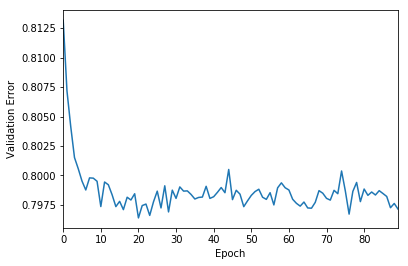

In [0]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

The minimum MSE is 0.796, which is better than our baseline values. Let's see if this can be improved with more latent factors.

### Three Latent Factors

In [0]:
# Experiment five - Recommender System using Matrix Factorization
# 3 Latent Factors
n_latent_factors = 3

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [0]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 4s 45us/step - loss: 12.1686 - val_loss: 7.7053
Epoch 2/100
81191/81191 [==============================] - 3s 40us/step - loss: 4.3921 - val_loss: 2.5150
Epoch 3/100
81191/81191 [==============================] - 3s 40us/step - loss: 1.7681 - val_loss: 1.3573
Epoch 4/100
81191/81191 [==============================] - 3s 40us/step - loss: 1.0775 - val_loss: 0.9949
Epoch 5/100
81191/81191 [==============================] - 3s 41us/step - loss: 0.8569 - val_loss: 0.8705
Epoch 6/100
81191/81191 [==============================] - 3s 41us/step - loss: 0.7830 - val_loss: 0.8281
Epoch 7/100
81191/81191 [==============================] - 3s 41us/step - loss: 0.7577 - val_loss: 0.8156
Epoch 8/100
81191/81191 [==============================] - 3s 41us/step - loss: 0.7487 - val_loss: 0.8094
Epoch 9/100
81191/81191 [==============================] - 3s 40us/step - loss: 0.7447 - val_loss: 0.8

Minimum MSE:  0.7578070477539778


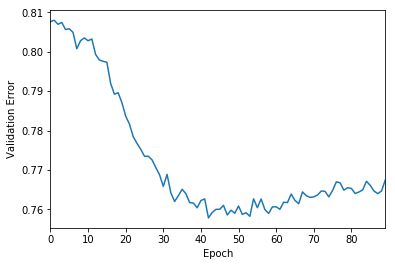

In [0]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

The minimum MSE here is 0.758, so far the best.

### Five Latent Factors



In [0]:
# Experiment six - Recommender System using Matrix Factorization
# 5 Latent Factors
n_latent_factors = 5

user_input = Input(shape=[1], name='user')
user_embedding = Embedding(input_dim=n_users + 1, \
                           output_dim=n_latent_factors, \
                           embeddings_regularizer=regularizers.l1(10e-7), \
                           name='user_embedding')(user_input)
user_vec = Flatten(name='flatten_users')(user_embedding)

movie_input = Input(shape=[1], name='movie')
movie_embedding = Embedding(input_dim=n_movies + 1, \
                            output_dim=n_latent_factors, \
                            embeddings_regularizer=regularizers.l1(10e-7), \
                            name='movie_embedding')(movie_input)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

product = dot([movie_vec, user_vec], axes=1)
model = Model(inputs=[user_input, movie_input], outputs=product)
model.compile('adam', 'mean_squared_error')

In [0]:
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], \
                    y=X_train.rating, epochs=100, \
                    validation_data=([X_validation.newUserId, \
                    X_validation.newMovieId], X_validation.rating), \
                    verbose=1)

Train on 81191 samples, validate on 4511 samples
Epoch 1/100
81191/81191 [==============================] - 4s 47us/step - loss: 10.9135 - val_loss: 5.2047
Epoch 2/100
81191/81191 [==============================] - 3s 42us/step - loss: 2.8242 - val_loss: 1.6737
Epoch 3/100
81191/81191 [==============================] - 4s 44us/step - loss: 1.2164 - val_loss: 1.0257
Epoch 4/100
81191/81191 [==============================] - 4s 44us/step - loss: 0.8691 - val_loss: 0.8723
Epoch 5/100
81191/81191 [==============================] - 3s 42us/step - loss: 0.7823 - val_loss: 0.8274
Epoch 6/100
81191/81191 [==============================] - 3s 42us/step - loss: 0.7591 - val_loss: 0.8174
Epoch 7/100
81191/81191 [==============================] - 3s 42us/step - loss: 0.7526 - val_loss: 0.8134
Epoch 8/100
81191/81191 [==============================] - 3s 41us/step - loss: 0.7500 - val_loss: 0.8116
Epoch 9/100
81191/81191 [==============================] - 3s 42us/step - loss: 0.7499 - val_loss: 0.8

Minimum MSE:  0.7576441799714332


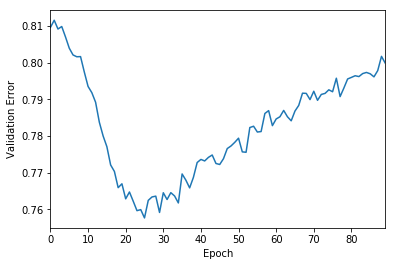

In [0]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

This experiment shown overfitting from epoch 25 onwards. The MSE reachesist minimum of 0.758 and then fails to improve. A better result was achieved with 3 latent factors.


## Colaborative Filtering Using RBMs

Let's recall the architecture of RMBs. They have two layers: an input and hidden. Neurons are connected to neurons in other layers but not to neurons in the same layer.

One difference RMBs have compared to autoencoders is that the communication between layers in RBMs happens in both directions whereas in autoencoders only in the forward direction.

In RMBs the input data gets passed from the visible layer to the hidden one and back several times. This develops a *generative model* that produces an output similar to the input data.

In our case, an RMB will try to generate a rating prediction on a movie a user have never seen based on how similar the movie is to those the user rated before and how similar the user is to users that rated the movie.

The input layer will have X neurons, X equal to the number of movies ( $n$) in the datase. Each neuron will have a value of the normalized rating in range 0 to 1 with 0 meaning the user never rated the movie and 1 means the highest rating. The neuron in the visible layer will communicate with those in the hidden layer trying to learn latent factors and produce a generative model to make rating predictions.


### RBM Neural Network Architecture

For the RBM-based recommender we will use the rating matrix of the dimensions $m \times n$. Here, $m$ is the number of users and $n$ is the number of movies. Each input $X$ that is passed to the input layer will have $n$ ratings ranging from 0 to 1. This means the input layer will have to have also $n$ neurons.

The inputs are passed in batches of $k$ users and the network is trained for a specified number of epochs.

We can design the hidden layer to have fewer nodes than $n$ thus forcing it to learn the most salient features and generalize better.

The process starts with the input vector $v0$ that is passed to the visible layer. On its way to the hidden layer, the $v0$ vector is multiplied by the weights vector $W$. Additionally, a bias vector $hb$ is added guaranteeing that at least some neurons will fire. Before going through the activation function of the hidden layer the inputs then look like this:
$$
W*v0 + hb
$$

After the vector is passed through the activation function, we take a sample of them using what is called *Gibbs sampling*. This makes the RBM to produce the results stochastically which makes it more robust.

The result of the sampling of the hidden layer output is marked $h0$ and is send in a *backward* pass to the visible layer. It is also multiplied by the same weights $W$ and a bias vector $vb$ is added at the visible layer. The ney input is therefore:

$$
W*h0 + vb
$$

This is then passes through the activation function of the visible layer, and is sampled using Gibbs sampling before going forward to the hidden layer in the next epoch.

The RBM performs these back-and -forth passes several times learning the optimal weights that minimize the Kullback-Leibler distance between the original distribution and the learned probability distribution.


### Build the Components of the RBM Class

First, we need to specify the parameters to the RBM class. They are:

 - Input size
 - Output size
 - Learning rate
 - Number of epochs
 - Batch size that we will use during the training
 
We will also create zero matrices for the weight matrix, hidden and visible bias vectors.




In [0]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
        
    def prob_h_given_v(self, visible, w, hb):
        ''' Forward pass: multiplying the visible input by weights and 
        adding the hidden bias vector
        '''
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    def prob_v_given_h(self, hidden, w, vb):
        '''Backward pass: multplying by weights and adding the visiblt
        bias vector.'''
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        '''Perform Gibbs sampling
        '''
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        # Placeholders for weight, hidden and visible bias vectors
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        # containers to keep values of previous and current 
        # weights and bias vectors
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        # Perform forward and backward passes
        # note that the weights matrix is the same in the forward and backward
        # passes
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        
        # Perform the forward pass again
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        # update weights and bias vectors using Contrastive Divergence
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * \
            (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        # Error is defined as MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), \
                        self.batchsize),range(self.batchsize,len(X), \
                                              self.batchsize)):
                    # the zip returns a tuple with start indicating
                    # the beginning index of the batch, and end indicating
                    # the end of the batch (start plus batch size)
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, \
                                    _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, \
                                _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

### Train the RBM Recommender

To train the recommneder we will generate an input array `inputX` from the `ratings_train` and convert its values to `float32`. Then we initialize an instance of the RBM class with the initial parameters like these:

 - input and output sizes: 1000
 - learning rate 0.3
 - epoch number 500
 - batch size: 200
 
These parameter values can be experimented with to achieve better results.

In [0]:
# Begin the training cycle

# Convert inputX into float32
inputX = ratings_train
inputX = inputX.astype(np.float32)

# Define the parameters of the RBMs we will train
rbm=RBM(1000,1000,1,1000,200)

In [0]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Text(0, 0.5, 'Reconstruction Error')

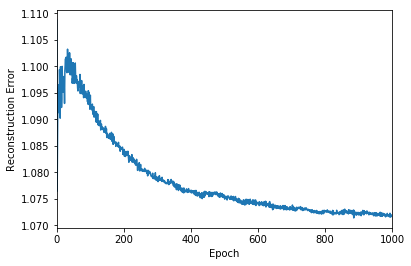

In [23]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

One can see that with longer training the reconstruction error decreases.

Now, lets take the trained RMB to predict the ratings for users in the validation set (this one has the same users as the training set):

In [0]:
# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)

finalOutput_validation, reconstructedOutput_validation, _ = \
    rbm.rbm_output(inputValidation)

We will convert the predicstions into an array and calculate the MSE against the true validation ratings:


In [25]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = \
    predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = \
    ratings_validation[ratings_validation.nonzero()].flatten()

rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 9.35618488140102


We would need to perform more experiments to improve this initial error value.


## Conclusion

We have used restricted Bolztmann machines to build a recommender hat tries to learn the distribution from the training data tp make predictions on the never before seen samples.